In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error, mean_absolute_error
torch.set_default_dtype(torch.float64)
import time
from scipy.stats import qmc
import os
import subprocess


c:\Users\sozenosk\AppData\Local\miniforge3\envs\moldflow\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


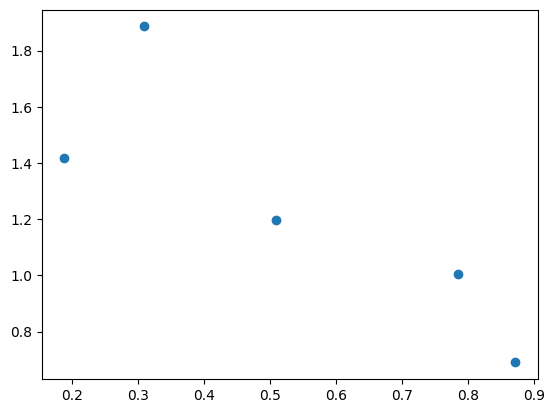

In [2]:
# Generating inital values for Wall slip parameters

tau_w_range = [0.001, 1]  # critical shear stress
m_range = [0.5, 2]

lower= [0.001, 0.5]
upper = [1, 2]

sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(5)

scaled_values = qmc.scale(sample, lower, upper)
tau_w_values = scaled_values[:,0]
m_values = scaled_values[:,1]
plt.scatter(tau_w_values, m_values)
plt.show()


In [7]:
Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"


Synergy.OpenProject("H:\\Moldflow_Projects\\wall_slip\\wall_slip.mpi")
Project = Synergy.Project
Project.OpenItemByName("60SurfaceCoverage_study", "Study")

# Simulation loop for wall slip parameters
for i in range(5):
    tau_w = tau_w_values[i]
    m = m_values[i]
    print(f"Simulation {i+1} with tau_w : {tau_w} and m: {m}")

    study_name =f"study_{i+1}"
    Project = Synergy.Project
    
    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(tau_w)
    DVec.AddDouble(m)
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
          
    PropEd.CommitChanges("Process Conditions")

    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)

    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"H:\\Moldflow_Projects\\wall_slip\\study_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()





# Write the output to a log file
    with open(f"H:\\Log_Files\\study_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

Simulation 1 with tau_w : 0.8718033626949936 and m: 0.6902771758022428
Simulation 2 with tau_w : 0.18857964875018965 and m: 1.4172253444654668
Simulation 3 with tau_w : 0.3088548503270038 and m: 1.8861271607958932
Simulation 4 with tau_w : 0.7857232650890262 and m: 1.004388075953903
Simulation 5 with tau_w : 0.5086161186898042 and m: 1.196282544891792
